# Q1
What percentage of shipments met the on-time delivery threshold (arriving no later than 30 minutes past the scheduled delivery window) between October 1st and December 31st, 2023?

# 1. Library Import

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import helper

from datetime import datetime
from datetime import timedelta

# 2. Data Loading

In [2]:
df_GPS = pd.read_csv('Data/GPS_data.csv')
df_bookings = pd.read_csv('Data/Shipment_bookings.csv')
df_new_bookings = pd.read_csv('Data/New_bookings.csv')
print(df_bookings.shape, df_new_bookings.shape, df_GPS.shape)

(3245, 15) (1000, 15) (641662, 4)


In [3]:
df_GPS.columns

Index(['SHIPMENT_NUMBER', 'LAT', 'LON', 'RECORD_TIMESTAMP'], dtype='object')

In [4]:
df_GPS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641662 entries, 0 to 641661
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SHIPMENT_NUMBER   641662 non-null  object 
 1   LAT               641662 non-null  float64
 2   LON               641662 non-null  float64
 3   RECORD_TIMESTAMP  641662 non-null  object 
dtypes: float64(2), object(2)
memory usage: 19.6+ MB


In [5]:
df_bookings.columns

Index(['PROJECT_ID', 'SHIPMENT_NUMBER', 'CARRIER_DISPLAY_ID', 'VEHICLE_SIZE',
       'VEHICLE_BUILD_UP', 'FIRST_COLLECTION_POST_CODE',
       'LAST_DELIVERY_POST_CODE', 'FIRST_COLLECTION_LATITUDE',
       'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'FIRST_COLLECTION_SCHEDULE_EARLIEST',
       'FIRST_COLLECTION_SCHEDULE_LATEST', 'LAST_DELIVERY_SCHEDULE_EARLIEST',
       'LAST_DELIVERY_SCHEDULE_LATEST'],
      dtype='object')

In [6]:
df_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PROJECT_ID                          3245 non-null   object 
 1   SHIPMENT_NUMBER                     3245 non-null   object 
 2   CARRIER_DISPLAY_ID                  3245 non-null   object 
 3   VEHICLE_SIZE                        3245 non-null   object 
 4   VEHICLE_BUILD_UP                    3245 non-null   object 
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object 
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object 
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64
 9   LAST_DELIVERY_LATITUDE              3245 non-null   float64
 10  LAST_DELIVERY_LONGITUDE             3245 non-null   float64
 11  FIRST_COLLECTION_SCHEDULE_EARLIEST  3245 no

In [7]:
df_new_bookings.columns

Index(['SHIPMENT_NUMBER', 'SHIPPER_ID', 'CARRIER_ID', 'VEHICLE_SIZE',
       'VEHICLE_BUILD_UP', 'FIRST_COLLECTION_POST_CODE',
       'LAST_DELIVERY_POST_CODE', 'FIRST_COLLECTION_LATITUDE',
       'FIRST_COLLECTION_LONGITUDE', 'LAST_DELIVERY_LATITUDE',
       'LAST_DELIVERY_LONGITUDE', 'FIRST_COLLECTION_SCHEDULE_EARLIEST',
       'FIRST_COLLECTION_SCHEDULE_LATEST', 'LAST_DELIVERY_SCHEDULE_EARLIEST',
       'LAST_DELIVERY_SCHEDULE_LATEST'],
      dtype='object')

In [8]:
df_new_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SHIPMENT_NUMBER                     1000 non-null   object 
 1   SHIPPER_ID                          1000 non-null   object 
 2   CARRIER_ID                          1000 non-null   object 
 3   VEHICLE_SIZE                        1000 non-null   object 
 4   VEHICLE_BUILD_UP                    1000 non-null   object 
 5   FIRST_COLLECTION_POST_CODE          998 non-null    object 
 6   LAST_DELIVERY_POST_CODE             1000 non-null   object 
 7   FIRST_COLLECTION_LATITUDE           1000 non-null   float64
 8   FIRST_COLLECTION_LONGITUDE          1000 non-null   float64
 9   LAST_DELIVERY_LATITUDE              1000 non-null   float64
 10  LAST_DELIVERY_LONGITUDE             1000 non-null   float64
 11  FIRST_COLLECTION_SCHEDULE_EARLIEST  1000 non

__Observations__

* SHIPPER_ID is missing from Shipment_bookings dataset
* 4 LAST_DELIVERY_POST_CODEs are missing from Shipment_bookings
* 2 FIRST_COLLECTION_POST_CODEs are missing from New_bookings dataset

# 3. Pre-Processing

## 3.1 Date Formatting

In [9]:
# convert to datetime format 
date_cols = ['FIRST_COLLECTION_SCHEDULE_EARLIEST', 
             'FIRST_COLLECTION_SCHEDULE_LATEST', 
             'LAST_DELIVERY_SCHEDULE_EARLIEST',
             'LAST_DELIVERY_SCHEDULE_LATEST',
             'RECORD_TIMESTAMP']
datasets = [df_bookings, df_new_bookings, df_GPS]

for data in datasets:
    for col in date_cols:
        if (col in data.columns):
            data[col]=pd.to_datetime(data[col])

In [10]:
df_bookings[['FIRST_COLLECTION_SCHEDULE_EARLIEST', 
             'FIRST_COLLECTION_SCHEDULE_LATEST', 
             'LAST_DELIVERY_SCHEDULE_EARLIEST',
             'LAST_DELIVERY_SCHEDULE_LATEST']].describe()

,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
count,3245,3245,3245,3245
mean,2023-11-18 16:32:19.085978368+00:00,2023-11-18 19:10:45.564252416+00:00,2023-11-19 06:36:37.944529920+00:00,2023-11-19 07:58:31.620647168+00:00
min,2023-09-29 14:00:00+00:00,2023-10-01 01:00:00+00:00,2023-10-01 03:00:00+00:00,2023-10-01 03:30:00+00:00
25%,2023-10-27 10:00:00+00:00,2023-10-27 10:30:00+00:00,2023-10-27 16:30:00+00:00,2023-10-27 17:00:00+00:00
50%,2023-11-20 22:19:00+00:00,2023-11-21 01:00:00+00:00,2023-11-21 09:30:00+00:00,2023-11-21 10:30:00+00:00
75%,2023-12-12 07:30:00+00:00,2023-12-12 13:00:00+00:00,2023-12-12 19:00:00+00:00,2023-12-12 20:00:00+00:00
max,2023-12-31 00:30:00+00:00,2023-12-31 01:00:00+00:00,2024-01-03 10:25:00+00:00,2024-01-03 10:55:00+00:00


In [11]:
df_new_bookings[['FIRST_COLLECTION_SCHEDULE_EARLIEST', 
             'FIRST_COLLECTION_SCHEDULE_LATEST', 
             'LAST_DELIVERY_SCHEDULE_EARLIEST',
             'LAST_DELIVERY_SCHEDULE_LATEST']].describe()

,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
count,1000,1000,1000,1000
mean,2024-01-15 02:49:43.573000192+00:00,2024-01-15 06:22:47.230000128+00:00,2024-01-15 18:17:38.884999936+00:00,2024-01-15 20:52:49.081999872+00:00
min,2024-01-09 12:00:00+00:00,2024-01-10 00:30:00+00:00,2024-01-10 04:30:00+00:00,2024-01-10 05:00:00+00:00
25%,2024-01-12 03:11:45+00:00,2024-01-12 05:45:00+00:00,2024-01-12 11:30:00+00:00,2024-01-12 15:59:00+00:00
50%,2024-01-15 15:00:00+00:00,2024-01-15 18:00:00+00:00,2024-01-16 07:32:00+00:00,2024-01-16 08:57:30+00:00
75%,2024-01-17 15:00:00+00:00,2024-01-17 18:07:30+00:00,2024-01-18 07:32:00+00:00,2024-01-18 09:27:30+00:00
max,2024-01-20 23:45:00+00:00,2024-01-20 23:59:24+00:00,2024-01-23 19:30:00+00:00,2024-01-23 19:45:00+00:00


In [12]:
df_GPS['RECORD_TIMESTAMP'].describe()

count                        641662
unique                       121350
top       2023-12-20 07:26:00+00:00
freq                             28
Name: RECORD_TIMESTAMP, dtype: object

## 3.2 Data Cleaning

In [13]:
# remove all GPS records except the latest

df_GPS_latest = df_GPS.sort_values(by='RECORD_TIMESTAMP', ascending=False).drop_duplicates(subset='SHIPMENT_NUMBER', keep='first')
df_GPS_latest.shape

(3245, 4)

## 3.2 Merge GPS data

In [14]:
df_train=df_bookings.merge(df_GPS_latest, how='left', on='SHIPMENT_NUMBER')
df_train.shape

(3245, 18)

In [15]:
df_train[['SHIPMENT_NUMBER', 'LAT', 'LON', 'RECORD_TIMESTAMP', 'LAST_DELIVERY_SCHEDULE_LATEST','LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE']].head()

,SHIPMENT_NUMBER,LAT,LON,RECORD_TIMESTAMP,LAST_DELIVERY_SCHEDULE_LATEST,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE
0,SEZHUK-231005-250448,52.316544,-0.157263,2023-10-06 10:24:00+01:00,2023-10-09 10:25:00+00:00,55.877803,-3.648558
1,SEZHUK-231217-275004,53.745423,-1.702855,2023-12-20 04:08:00+00:00,2023-12-20 08:56:00+00:00,51.398851,-1.231993
2,SEZHUK-231210-272018,51.659889,-0.024926,2023-12-14 10:18:00+00:00,2023-12-14 10:43:00+00:00,51.660700,-0.022247
3,SEZHUK-231211-272127,52.889862,-0.634389,2023-12-13 17:22:00+00:00,2023-12-13 16:00:00+00:00,52.888113,-0.634948
4,SEZHUK-231025-256168,55.845446,-3.880531,2023-11-08 03:53:00+00:00,2023-11-07 23:59:00+00:00,55.735089,-4.168719


In [16]:
select_cols = ['SHIPMENT_NUMBER', 'LAT', 'LON', 'LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE', 'RECORD_TIMESTAMP', 'LAST_DELIVERY_SCHEDULE_LATEST',]

In [47]:
df = df_train.copy()

In [48]:
df['RECORD_TIMESTAMP'].min(), df['RECORD_TIMESTAMP'].max()

(Timestamp('2023-10-01 01:46:00+0100', tz='UTC+01:00'),
 Timestamp('2023-12-30 23:59:00+0000', tz='UTC'))

## 3.4 Postcode Lookup API

In [49]:
# combine lon & lat columns into 1 GPS coordinates column

df['GPS_coord']=df[['LAT', 'LON']].values.tolist()

df[['LAT', 'LON','GPS_coord']].head()

,LAT,LON,GPS_coord
0,52.316544,-0.157263,"[52.31654422, -0.15726316]"
1,53.745423,-1.702855,"[53.7454231574671, -1.70285456004236]"
2,51.659889,-0.024926,"[51.659889300233104, -0.024926167738865]"
3,52.889862,-0.634389,"[52.8898615976303, -0.63438873938486]"
4,55.845446,-3.880531,"[55.8454462753676, -3.88053080781484]"


In [50]:
# test post code lookup function
postcode = helper.get_postcode_from_gps(df.iloc[0]['GPS_coord'])
print(f"The postcode is: {postcode}")

The postcode is: PE29 2XJ


### 3.4.1 Imputation

In [51]:
# Impute missing values in LAST_DELIVERY_POST_CODE

df['last_delivery_coord']=df[['LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE']].values.tolist() # combine the GPS coordinates
df[df['LAST_DELIVERY_POST_CODE'].isna()][['last_delivery_coord', 'LAST_DELIVERY_POST_CODE']] # inspect missing postcodes

,last_delivery_coord,LAST_DELIVERY_POST_CODE
1408,"[53.215555, -6.675042]",NaN
1950,"[51.76935, 0.08155]",NaN
2088,"[51.76935, 0.08155]",NaN
2744,"[51.76935, 0.08155]",NaN


In [52]:
df_missing_pc = pd.DataFrame(df[df['LAST_DELIVERY_POST_CODE'].isna()]['last_delivery_coord']) # create dataframe with only missing postcodes
df_missing_pc['last_delivery_postcode']=df_missing_pc['last_delivery_coord'].apply(helper.get_postcode_from_gps) # apply function to convert coodinates to postcode
df_missing_pc

,last_delivery_coord,last_delivery_postcode
1408,"[53.215555, -6.675042]",No postcode found for the given coordinates.
1950,"[51.76935, 0.08155]",No postcode found for the given coordinates.
2088,"[51.76935, 0.08155]",No postcode found for the given coordinates.
2744,"[51.76935, 0.08155]",No postcode found for the given coordinates.


__Finding__

* No postcode found for the given coordinates

In [53]:
# delete rows that contain missing LAST_DELIVERY_POST_CODE
df=df.dropna(subset=['LAST_DELIVERY_POST_CODE'])
df.shape

(3241, 20)

### 3.4.2 Convert to Postcode Using Function

In [54]:
df['POSTCODE'] = df['GPS_coord'].apply(helper.get_postcode_from_gps)

In [55]:
# check how many postcodes are found
df[df['POSTCODE']!='No postcode found for the given coordinates.'].shape[0]

1424

In [56]:
# check number of shipments & % that reached destination
print(df[df['POSTCODE']==df['LAST_DELIVERY_POST_CODE']].shape[0])
print(df[df['POSTCODE']==df['LAST_DELIVERY_POST_CODE']].shape[0]/df.shape[0])

495
0.1527306386917618


In [57]:
df['reached_delivery_loc']= np.where(df['POSTCODE']==df['LAST_DELIVERY_POST_CODE'], 1, 0)
df['reached_delivery_loc'].value_counts()

reached_delivery_loc
0    2746
1     495
Name: count, dtype: int64

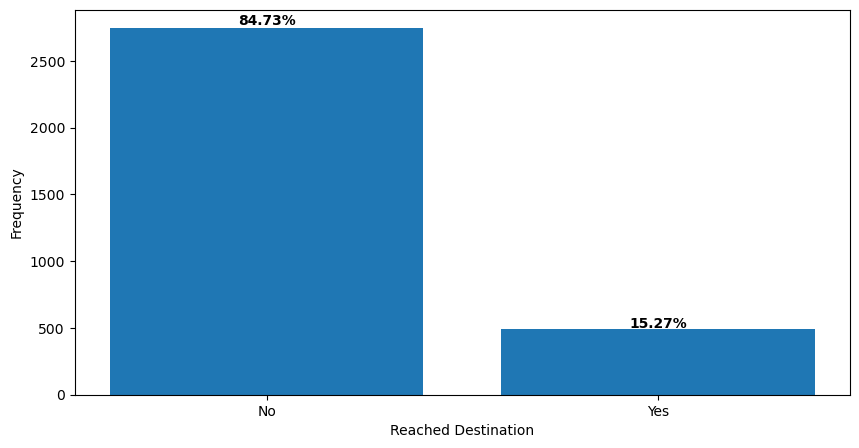

In [58]:
# Distribution Plot of Carriers that Reached Delivery Location
helper.plot_class_distribution('reached_delivery_loc', df, 'Reached Destination', [0, 1], ['No', 'Yes'])

__Observation__
* Only 15.3% of shipments reach their destination

In [59]:
## look for matches that are not exact but close enough
df[(df['POSTCODE']!='No postcode found for the given coordinates.')&(df['POSTCODE']!=df['LAST_DELIVERY_POST_CODE'])][['LAT', 'LON','LAST_DELIVERY_LATITUDE', 'LAST_DELIVERY_LONGITUDE','POSTCODE', 'LAST_DELIVERY_POST_CODE']].head(20)

,LAT,LON,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,POSTCODE,LAST_DELIVERY_POST_CODE
0,52.316544,-0.157263,55.877803,-3.648558,PE29 2XJ,EH48 2FB
5,52.479792,-1.974671,52.829374,-1.332134,B67 5QS,DE74 2TR
10,52.240277,0.717603,52.236599,0.717008,IP33 2AD,IP33 2JG
14,53.794882,-1.762643,52.641456,-1.216005,BD1 2HS,LE3 8DX
15,51.126472,-2.742023,53.534344,-1.035929,BA16 0EW,DN3 3FQ
16,51.662387,-0.024415,51.659325,-0.021793,EN3 7RG,EN3 7QP
21,51.745884,-0.223657,51.771839,-0.439712,AL10 8UP,HP2 7PZ
23,52.871596,-1.493740,52.106487,1.098275,DE24 3DR,IP6 0JW
24,53.178576,-1.041729,53.295391,-1.066283,NG22 9DD,S80 3EG
28,52.588214,-2.074503,52.371658,-1.452326,WV13 3BL,CV8 3ED


__Findings__
* row 43's GPS postcode SP4 7GR matches the delivery postcode  SP4 7GQ (except the last character)
* similarly, the difference in lattitudes & longitudes are very close# 
* hence, we can potentially use this rule as a match instread of an exact match

In [60]:
# re-define reaching delivery location by close match instead of exact match
df['almost_reached_delivery_loc']= np.where(df['POSTCODE'].str[:-1]==df['LAST_DELIVERY_POST_CODE'].str[:-1], 1, 0)
df['almost_reached_delivery_loc'].value_counts()

almost_reached_delivery_loc
0    2656
1     585
Name: count, dtype: int64

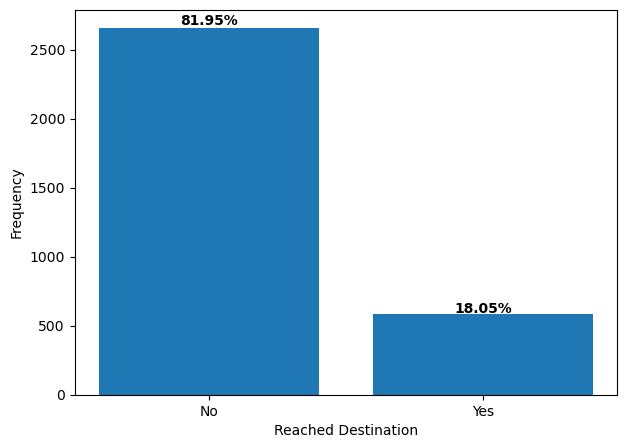

In [63]:
# Distribution Plot of Carriers that almost Reached Delivery Location
helper.plot_class_distribution('almost_reached_delivery_loc', df, 'Reached Destination', [0, 1], ['No', 'Yes'])

# 4. Identify On Time Shipment 

### 4.1 Exact Postcode Match

In [64]:
# find shipment that's on time by checking that it reaches its destination based on exact postcode match
# no later than 30 minutes after its latest scheduled delivery time

df['on_time'] = np.where((df['reached_delivery_loc']==1)&(df['RECORD_TIMESTAMP']<=(df['LAST_DELIVERY_SCHEDULE_LATEST'] + timedelta(minutes=30))), 1, 0)

### 4.2 Close Postcode Match

In [65]:
# find shipment that's on time by checking that it reaches its destination 
# no later than 30 minutes after its latest scheduled delivery time
# based on close postcode match where only the last character doesn't match

df['almost_on_time'] = np.where((df['almost_reached_delivery_loc']==1)&(df['RECORD_TIMESTAMP']<=(df['LAST_DELIVERY_SCHEDULE_LATEST'] + timedelta(minutes=30))), 1, 0)

In [66]:
# inspect shipments that were on time
df[df['on_time']==1][['POSTCODE', 'RECORD_TIMESTAMP', 'LAST_DELIVERY_POST_CODE', 'LAST_DELIVERY_SCHEDULE_LATEST']]

,POSTCODE,RECORD_TIMESTAMP,LAST_DELIVERY_POST_CODE,LAST_DELIVERY_SCHEDULE_LATEST
7,LS27 0FU,2023-12-09 04:23:00+00:00,LS27 0FU,2023-12-09 05:30:00+00:00
36,RM19 1ND,2023-12-16 15:26:00+00:00,RM19 1ND,2023-12-16 15:00:00+00:00
41,RG19 4BQ,2023-11-30 10:06:00+00:00,RG19 4BQ,2023-11-30 10:33:01+00:00
54,HP5 1QJ,2023-10-05 11:00:00+01:00,HP5 1QJ,2023-10-05 11:59:00+00:00
58,RG19 4BQ,2023-11-08 23:49:00+00:00,RG19 4BQ,2023-11-09 02:30:00+00:00
...,...,...,...,...
3193,B66 2LF,2023-11-01 13:48:00+00:00,B66 2LF,2023-11-01 14:00:00+00:00
3217,ME13 7TW,2023-12-08 09:55:00+00:00,ME13 7TW,2023-12-08 10:51:01+00:00
3223,BT36 7LQ,2023-10-13 10:37:00+01:00,BT36 7LQ,2023-10-13 10:00:00+00:00
3230,CW1 6FB,2023-11-06 19:35:00+00:00,CW1 6FB,2023-11-07 19:30:00+00:00


In [67]:
df[(df['almost_on_time']==1)].shape[0]

444

In [68]:
df[(df['almost_on_time']==1)&(df['on_time']==0)][['POSTCODE', 'RECORD_TIMESTAMP', 'LAST_DELIVERY_POST_CODE', 'LAST_DELIVERY_SCHEDULE_LATEST']]

,POSTCODE,RECORD_TIMESTAMP,LAST_DELIVERY_POST_CODE,LAST_DELIVERY_SCHEDULE_LATEST
43,SP4 7GR,2023-12-30 12:54:00+00:00,SP4 7GQ,2023-12-30 13:25:00+00:00
60,BN1 8AT,2023-10-17 13:40:00+01:00,BN1 8AF,2023-10-17 16:00:00+00:00
200,S35 2PT,2023-10-02 19:28:00+01:00,S35 2PW,2023-10-02 20:42:01+00:00
278,ME13 7TZ,2023-12-01 03:23:00+00:00,ME13 7TW,2023-12-01 09:41:01+00:00
308,PA4 8DS,2023-10-03 08:34:00+01:00,PA4 8DJ,2023-10-03 08:00:00+00:00
...,...,...,...,...
3075,LE19 1WX,2023-11-22 15:27:00+00:00,LE19 1WY,2023-11-22 17:00:00+00:00
3083,BS35 3UU,2023-12-18 10:05:00+00:00,BS35 3UT,2023-12-18 12:22:00+00:00
3102,PL12 6LU,2023-10-05 05:59:00+01:00,PL12 6LX,2023-10-05 06:30:00+00:00
3141,EN11 0EW,2023-10-23 11:22:00+01:00,EN11 0EZ,2023-10-23 10:25:00+00:00


In [69]:
print('Percentage of on time delivery based on exact match:' , (df[df['on_time']==1].shape[0]/df.shape[0])*100, '%')

Percentage of on time delivery based on exact match: 11.693921629126812 %


In [70]:
print('Percentage of on time delivery based on close match:',df[df['almost_on_time']==1].shape[0]/df.shape[0], '%')

Percentage of on time delivery based on close match: 0.13699475470533787 %


__Observation__

* 379 out of 495 shipments that reach their destination, did so on time
* Only 11.7% reached their destination on time
* However, if we compare postcodes without the last character, assuming the item is close enough to its final destination 
the number & percentage are higher i.e. 444 and 13.7% 

__Assumptions__
* Shipment coordinates with no matching postcodes are shipments that didn't reach their destinations 
* However, these carriers might have had to park at coordinates that are not close enough to a matching postcode
* Also shipment postcodes that don't match the exact destination postcodes might have reached their destination by foot or other means due to parking

In [71]:
df['POSTCODE'].head()

0                                        PE29 2XJ
1    No postcode found for the given coordinates.
2    No postcode found for the given coordinates.
3    No postcode found for the given coordinates.
4    No postcode found for the given coordinates.
Name: POSTCODE, dtype: object

In [72]:
df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,LAT,LON,RECORD_TIMESTAMP,GPS_coord,last_delivery_coord,POSTCODE,reached_delivery_loc,almost_reached_delivery_loc,on_time,almost_on_time
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,52.316544,-0.157263,2023-10-06 10:24:00+01:00,"[52.31654422, -0.15726316]","[55.877803, -3.648558]",PE29 2XJ,0,0,0,0
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,53.745423,-1.702855,2023-12-20 04:08:00+00:00,"[53.7454231574671, -1.70285456004236]","[51.398851, -1.231993]",No postcode found for the given coordinates.,0,0,0,0
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,51.659889,-0.024926,2023-12-14 10:18:00+00:00,"[51.659889300233104, -0.024926167738865]","[51.6607, -0.022247]",No postcode found for the given coordinates.,0,0,0,0
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,52.889862,-0.634389,2023-12-13 17:22:00+00:00,"[52.8898615976303, -0.63438873938486]","[52.888113, -0.634948]",No postcode found for the given coordinates.,0,0,0,0
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,55.845446,-3.880531,2023-11-08 03:53:00+00:00,"[55.8454462753676, -3.88053080781484]","[55.735089, -4.168719]",No postcode found for the given coordinates.,0,0,0,0


In [73]:
df.shape[0]

3241

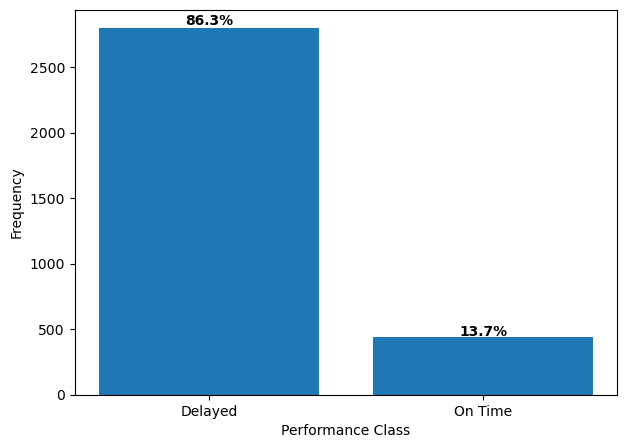

In [74]:
helper.plot_class_distribution('almost_on_time', df, 'Performance Class', [0, 1], ['Delayed', 'On Time'])

# 5. Save Dataset

In [75]:
df.to_csv('Data/bookings_processed.csv', index=False)